In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


### train_test_split

In [5]:
train, valid = train_test_split(data, test_size=0.3, random_state=500)

### Prepare data

In [6]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [7]:
train.shape

(7000, 20)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 7277 to 951
Data columns (total 20 columns):
Id               7000 non-null int64
DistrictId       7000 non-null int64
Rooms            7000 non-null float64
Square           7000 non-null float64
LifeSquare       5509 non-null float64
KitchenSquare    7000 non-null float64
Floor            7000 non-null int64
HouseFloor       7000 non-null float64
HouseYear        7000 non-null int64
Ecology_1        7000 non-null float64
Ecology_2        7000 non-null object
Ecology_3        7000 non-null object
Social_1         7000 non-null int64
Social_2         7000 non-null int64
Social_3         7000 non-null int64
Healthcare_1     3633 non-null float64
Helthcare_2      7000 non-null int64
Shops_1          7000 non-null int64
Shops_2          7000 non-null object
Price            7000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
def clean_rooms(df, source_df):
    df.loc[((df['Rooms'] < 1)|(df['Rooms'] > 5))&(df['Square'] < 50) , 'Rooms'] = 1
    df.loc[(df['Rooms'] > 5)&(df['Square'] < 61)&(df['Square'] > 50), 'Rooms'] = 2
    df.loc[(df['Rooms'] < 1)&(df['Square'] > 200), 'Rooms'] = 6
    df.loc[(df['Rooms'] < 1)&(df['Square'] > 61)&(df['Square'] < 200), 'Rooms'] = 5
    df.loc[(df['Rooms'] < 1)&(df['Square'] > 80)&(df['Square'] < 100), 'Rooms'] = 3
    df.loc[(df['Rooms'] < 1), 'Rooms'] = 2
    df.loc[(df['Rooms'] == 3)&(df['Square'] > 200), 'Rooms'] = 6
    return df

In [10]:
def clean_floor(df):
    id_floor_large_housefloor = df.loc[(df['Floor'] > df['HouseFloor'])&(df['HouseFloor'] != 0), 'Id'].values
    for id_ in id_floor_large_housefloor:
        df.loc[df['Id'] == id_, 'Floor'], df.loc[df['Id'] == id_, 'HouseFloor'] = df.loc[df['Id'] == id_, 'HouseFloor'], df.loc[df['Id'] == id_, 'Floor']
    return df

In [11]:
def clean_square(df):
    df.loc[df['Square'] < 15, 'Square'] = 15
    df.loc[df['KitchenSquare'] < 4, 'KitchenSquare'] = 4
    id_large_square = df.loc[((df['Rooms'] == 2)|(df['Rooms'] == 1))&(df['Square'] > 200) , 'Id'].values
    
    for id_ in id_large_square:
        df.loc[df['Id'] == id_, 'Square'] = df.loc[df['Id'] == id_, 'Square'] / 10
        #df.loc[df['Id'] == id_, 'LifeSquare'] = df.loc[df['Id'] == id_, 'LifeSquare'] / 10
    df.loc[(df['Rooms'] == 2)&(df['Square'] > 100), 'Rooms'] = 4
    df.loc[(df['Rooms'] == 5)&(df['Square'] < 50), 'Rooms'] = 2 #могут быть однушки!!!
    return df

In [12]:
def clean_year(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

In [13]:
#stat1 = train.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price']].mean().rename(columns={'Price':'mean_price1'})
#stat2 = train.groupby('Rooms', as_index=False)[['Price']].mean().rename(columns={'Price':'mean_price2'})
#mean_price = train['Price'].mean()

In [14]:
def add_mean_price(df, stat1, stat2, mean_price):
    df = pd.merge(df, stat1, on=['DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, stat2, on='Rooms', how='left')
    
    df['mean_price2'] = df['mean_price2'].fillna(mean_price)
    df['mean_price1'] = df['mean_price1'].fillna(df['mean_price2'])
    return df

In [15]:
def prepare_data(df, source_df=train, stat1=None, stat2=None, mean_price=None):
    df = df.drop('Healthcare_1', axis=1)
    df['Ecology_2'] = (df['Ecology_2'] == 'B').astype(int)
    df['Ecology_3'] = (df['Ecology_3'] == 'B').astype(int)
    df['Shops_2'] = (df['Shops_2'] == 'B').astype(int)

    df = clean_rooms(df, source_df)
    df = clean_floor(df)
    df = clean_square(df)
    df = clean_year(df)
    #df = add_mean_price(df, stat1, stat2, mean_price)
    return df

In [16]:
train = prepare_data(train)

In [17]:
valid = prepare_data(valid)

### диаграммы рассеивания

Text(0.5, 0, 'год постройки')

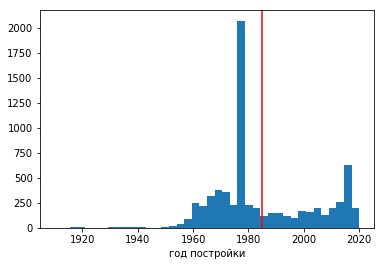

In [18]:
plt.hist(train['HouseYear'], bins=40)
plt.axvline(x=train['HouseYear'].mean(), color='red')
plt.xlabel('год постройки')

Text(0, 0.5, 'цена')

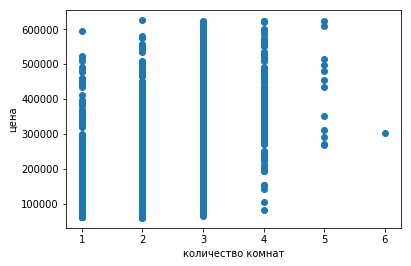

In [19]:
plt.scatter(train['Rooms'], train['Price'])
plt.xlabel('количество комнат')
plt.ylabel('цена')

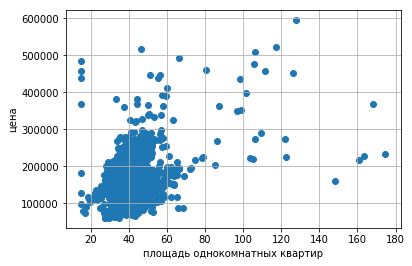

In [20]:
plt.scatter(train.loc[train['Rooms'] == 1, 'Square'], train.loc[train['Rooms'] == 1, 'Price']);
plt.xlabel('площадь однокомнатных квартир')
plt.ylabel('цена')
plt.grid(True)

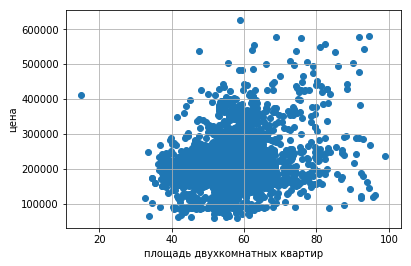

In [21]:
# 2 комнатные квартиры
plt.scatter(train.loc[train['Rooms'] == 2, 'Square'], train.loc[train['Rooms'] == 2, 'Price']);
plt.xlabel('площадь двухкомнатных квартир')
plt.ylabel('цена')
plt.grid(True)

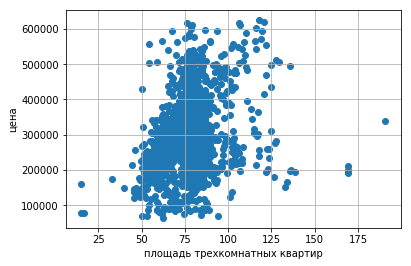

In [22]:
plt.scatter(train.loc[train['Rooms'] == 3, 'Square'], train.loc[train['Rooms'] == 3, 'Price']);
plt.xlabel('площадь трехкомнатных квартир')
plt.ylabel('цена')
plt.grid(True)

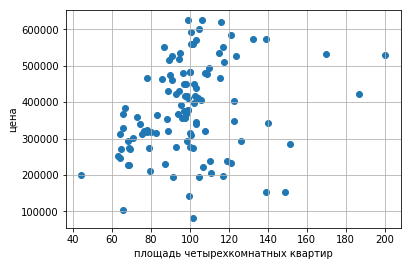

In [23]:
plt.scatter(train.loc[train['Rooms'] == 4, 'Square'], train.loc[train['Rooms'] == 4, 'Price']);
plt.xlabel('площадь четырехкомнатных квартир')
plt.ylabel('цена')
plt.grid(True)

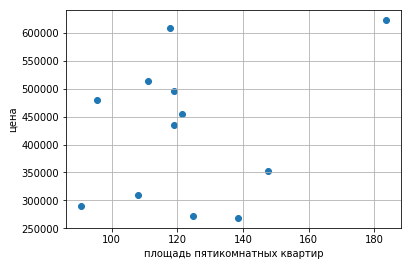

In [24]:
plt.scatter(train.loc[train['Rooms'] == 5, 'Square'], train.loc[train['Rooms'] == 5, 'Price']);
plt.xlabel('площадь пятикомнатных квартир')
plt.ylabel('цена')
plt.grid(True)

#### Корреляция признаков

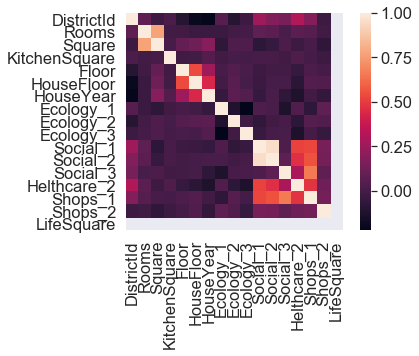

In [25]:
feats = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 
       'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 
       'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'LifeSquare']
cm = np.corrcoef(train[feats].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, square=True, fmt='.2f', yticklabels=feats, xticklabels=feats)
plt.show()

#### Масштабирование

In [26]:
# преведем все к типу float
def types_to_float(df, feats):

    for f in feats:
        df[f] = df[f].astype(float)
    return df

In [27]:
feats_not_float = ['DistrictId','Floor', 'HouseYear', 'Ecology_2', 'Ecology_3', 
        'Social_1', 'Social_2', 'Social_3', 
        'Helthcare_2', 'Shops_1', 'Shops_2']
train = types_to_float(train, feats_not_float)
valid = types_to_float(valid, feats_not_float)

In [28]:
# масштабирование всех признаков, кроме Id, LifeSquare и Price
feats = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 
       'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 
       'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

scaler = StandardScaler()

y_train = train.loc[:, 'Price']
y_valid = valid.loc[:, 'Price']

X_train_scaled = scaler.fit_transform(train.loc[:, feats])
X_valid_scaled = scaler.transform(valid.loc[:, feats])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feats)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=feats)

### Подбор оптимальных параметров для RandomForestRegression

In [29]:
# функция для подбора оптимальных параметров модели
def selection_best_param_RF(parameters, X_train, X_valid, y_train, y_valid):
    r2_acc_train = []
    r2_acc_valid = []
    r2_valid_max = 0
    best_param = {'n_estimators': None, 'max_depth': None, 'max_features':0.4, 'criterion':parameters['criterion']}
    
    for n_est in parameters['n_estimators']:
        r2_acc_dep_train = []
        r2_acc_dep_valid = []
        for max_dep in parameters['max_depth']:
                      
            rf_model = RF(n_estimators=n_est, max_depth=max_dep, min_samples_leaf=1, random_state=parameters['random_state'],
                              oob_score=True, max_features=0.4, criterion=parameters['criterion'] )
            rf_model.fit(X_train, y_train)
                
            pred_train = rf_model.predict(X_train)
            pred_valid = rf_model.predict(X_valid)
            
            r2_valid_temp = r2(y_valid, pred_valid)
            r2_train_temp = r2(y_train, pred_train)
            if r2_valid_temp > r2_valid_max:
                best_param['n_estimators'] = n_est
                best_param['max_depth'] = max_dep
                r2_valid_max = r2_valid_temp
            print(f'n_estimators = {n_est}, max_depth = {max_dep}')
            print(r2_train_temp)
            print(r2_valid_temp)
            print()
            
            r2_acc_dep_train.append(r2_train_temp)
            r2_acc_dep_valid.append(r2_valid_temp)
            
        r2_acc_train.append(r2_acc_dep_train)
        r2_acc_valid.append(r2_acc_dep_valid)
    print("=============")
    print(f"лучшие параметры n_estimators = {best_param['n_estimators']}, max_depth = {best_param['max_depth']}")
    print(f"лучшее значение r2_valid = {r2_valid_max}")

    r2_acc_train, r2_acc_valid = np.asarray(r2_acc_train), np.asarray(r2_acc_valid)
    return best_param, r2_acc_train, r2_acc_valid, r2_valid_max

In [30]:
# подбор n_estimators на масштабированных признаках
parameters_n = {'n_estimators': [110, 115, 120, 125, 130, 140], 'max_depth': [35], 'random_state': 500, 'criterion': 'mse'}

(best_param_rf_n, r2_train_array_n, r2_valid_array_n, r2_valid_max_n) = selection_best_param_RF(parameters_n, X_train_scaled, 
                                                                          X_valid_scaled, y_train, y_valid)

n_estimators = 110, max_depth = 35
0.9626563762926005
0.7464141100847712

n_estimators = 115, max_depth = 35
0.9629071098063038
0.7465815310230555

n_estimators = 120, max_depth = 35
0.9629146463901912
0.7468814708934802

n_estimators = 125, max_depth = 35
0.9629145669866743
0.7467884801274123

n_estimators = 130, max_depth = 35
0.9630472906672003
0.7460776966110079

n_estimators = 140, max_depth = 35
0.9631849054356879
0.7462184486186847

лучшие параметры n_estimators = 120, max_depth = 35
лучшее значение r2_valid = 0.7468814708934802


In [31]:
# подбор max_depth
parameters_d = {'n_estimators': [120], 'max_depth': [15, 20, 25, 30, 35, 40, 45, 50], 'random_state': 500, 'criterion': 'mse'}

(best_param_rf_d, r2_train_array_d, r2_valid_array_d, r2_valid_max_d) = selection_best_param_RF(parameters_d, X_train_scaled, 
                                                                          X_valid_scaled, y_train, y_valid)

n_estimators = 120, max_depth = 15
0.9382025660207138
0.7395053296733789

n_estimators = 120, max_depth = 20
0.9596769124225275
0.7403689853017024

n_estimators = 120, max_depth = 25
0.9622447285551574
0.7457589639207911

n_estimators = 120, max_depth = 30
0.9623242864323382
0.7427035387785714

n_estimators = 120, max_depth = 35
0.9629146463901912
0.7468814708934802

n_estimators = 120, max_depth = 40
0.9629333156400548
0.7467016041046983

n_estimators = 120, max_depth = 45
0.9629333156400548
0.7467016041046983

n_estimators = 120, max_depth = 50
0.9629333156400548
0.7467016041046983

лучшие параметры n_estimators = 120, max_depth = 35
лучшее значение r2_valid = 0.7468814708934802


### оценка результата подбора параметров моделирования

In [32]:
# фукнция рисует графики зависимости точности предсказания от параметра модели

def plot_r2(acc_train, acc_valid, name_param, param_grid, param_value=None, max_r2_valid=None):
    fig, ax = plt.subplots(nrows=2, ncols=1)
    ax1, ax2 = ax
    ax1.plot(param_grid, acc_train, alpha=0.5, color='blue', label='train')
    ax1.set_title('График r2(n_estimators) для train')
    ax2.plot(param_grid, acc_valid, alpha=0.5, color='red', label='valid')
    ax2.set_title('График r2(max_depth) для valid')
    if max_r2_valid is not None:
        ax2.scatter(param_value, max_r2_valid, c='blue', marker='o')
    ax1.grid(True)
    ax2.grid(True)

    ax1.set_ylabel("r2_train")
    ax2.set_ylabel("r2_valid")
    ax1.set_xlabel(name_param)
    ax2.set_xlabel(name_param)
    fig.set_size_inches(10, 10)
    plt.subplots_adjust(hspace=0.5)

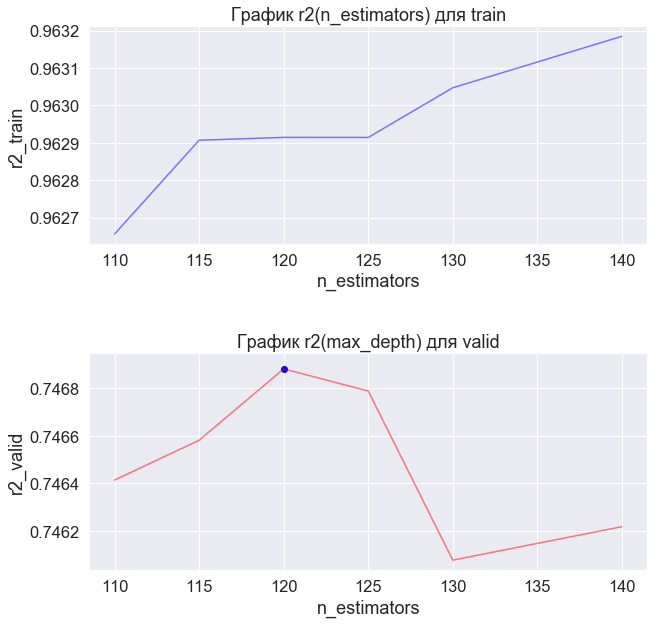

In [33]:
# 
plot_r2(r2_train_array_n.flatten(), r2_valid_array_n.flatten(), 'n_estimators', parameters_n['n_estimators'], 
        best_param_rf_n['n_estimators'], r2_valid_max_n)

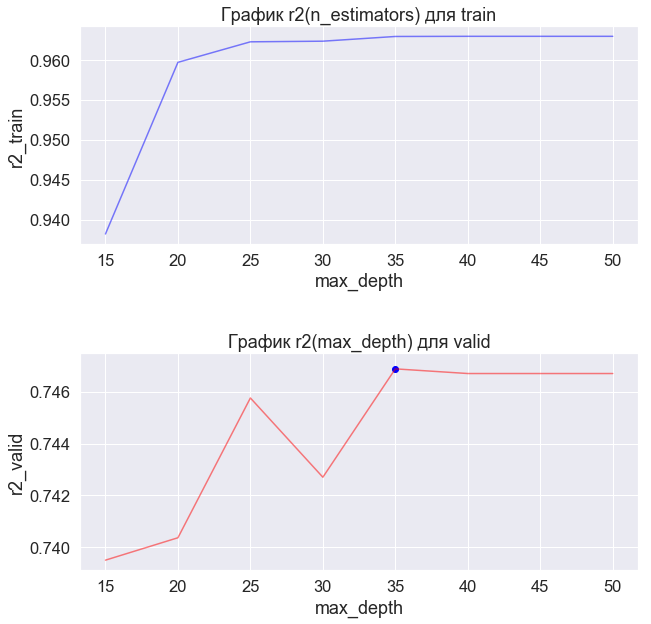

In [34]:
plot_r2(r2_train_array_d[0,:], r2_valid_array_d[0,:], 'max_depth', parameters_d['max_depth'], 
        best_param_rf_d['max_depth'], r2_valid_max_d)

### Моделирование на оптимальных параметрах

In [35]:
best_model_RF = RF(n_estimators=best_param_rf_d['n_estimators'], max_depth=best_param_rf_d['max_depth'], 
                  min_samples_leaf=1, random_state=500, oob_score=True, 
                  max_features=best_param_rf_d['max_features'], criterion=best_param_rf_d['criterion'])

In [36]:
best_model_RF.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features=0.4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
           oob_score=True, random_state=500, verbose=0, warm_start=False)

Ранжирование признаков:
1. Square 0.329977 
2. Rooms 0.128081 
3. Social_2 0.093977 
4. Social_1 0.071829 
5. Social_3 0.071127 
6. DistrictId 0.051911 
7. HouseYear 0.048658 
8. KitchenSquare 0.045946 
9. Ecology_1 0.042050 
10. HouseFloor 0.036400 
11. Floor 0.031301 
12. Shops_1 0.027111 
13. Helthcare_2 0.019007 
14. Ecology_3 0.001190 
15. Shops_2 0.000903 
16. Ecology_2 0.000530 


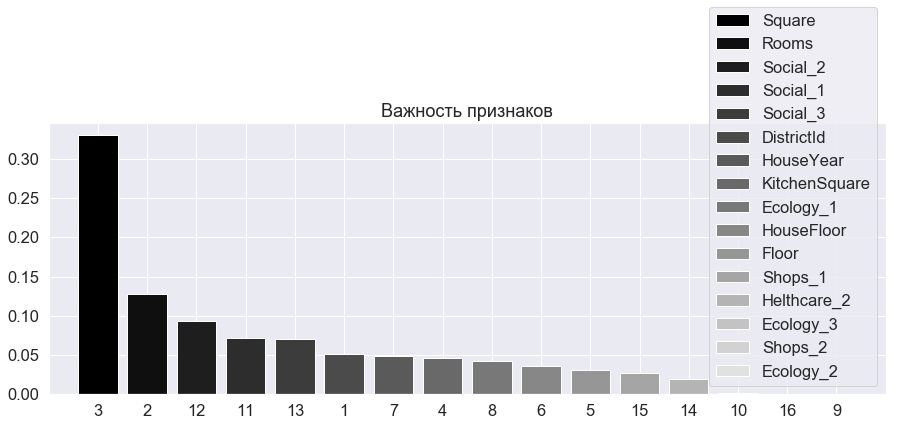

In [37]:
importances = best_model_RF.feature_importances_
indices = np.argsort(importances)[::-1]
num_to_plot = 16
feature_indices = [ind+1 for ind in indices[:num_to_plot]]
features = {"f1" :u'DistrictId',
            "f2" :u'Rooms',
            "f3" :u'Square',
            "f4" :u'KitchenSquare',
            "f5" :u'Floor',
            "f6" :u'HouseFloor',
            "f7" :u'HouseYear',
            "f8" :u'Ecology_1',
            "f9" :u'Ecology_2',
            "f10":u'Ecology_3',
            "f11":u'Social_1',
            "f12":u'Social_2',
            "f13":u'Social_3',
            "f14":u'Helthcare_2',
            "f15":u'Shops_1',
            "f16":u'Shops_2'}
# Print the feature ranking
print("Ранжирование признаков:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
    features["f"+str(feature_indices[f])], 
    importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность признаков")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

In [38]:
def evaluate_model(X, model, y=None):
    pred = model.predict(X)
    if y is not None:
        r2_ = r2(y, pred)
        print(f'r2 = {r2_}')
    return pred

In [39]:
pred_train = evaluate_model(X_train_scaled, best_model_RF, y_train)

r2 = 0.9629146463901912


In [40]:
pred_valid = evaluate_model(X_valid_scaled, best_model_RF, y_valid)

r2 = 0.7468814708934802


### Test

In [41]:
test = pd.read_csv('test.csv')

In [42]:
test = prepare_data(test)

In [43]:
feats_not_float = ['DistrictId','Floor', 'HouseYear', 'Ecology_2', 'Ecology_3', 
        'Social_1', 'Social_2', 'Social_3', 
        'Helthcare_2', 'Shops_1', 'Shops_2']
test = types_to_float(test, feats_not_float)

In [44]:
# масштабирование всех признаков, кроме Id, LifeSquare и Price
feats = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 
       'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 
       'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

test_scaled = scaler.transform(test.loc[:, feats])
test_scaled = pd.DataFrame(test_scaled, columns=feats)

In [45]:
test['Price'] = evaluate_model(test_scaled, best_model_RF)

In [46]:
test.loc[:, ['Id', 'Price']].to_csv('STchobanou_predictions.csv', index=None)